## **2B.** Do older planes suffer more delays?
(See Parts 1 to 5)
Here we use Python Query module to query the DB, then use R to query the DB as well to answer....perform a regression and visualise the regression to determine whether Plane age and delays correlate.


Retrospective questions: should we drop cancelled flights, as a data cleaning step?

In [1]:
'''
PART (0)
This script checks that there are no reassigned tailnums....

Since joins are a key part of the subsequent analysis, it would serve us well to perform a quick check that all tailnums are unique,
and have not been reassigned in the 20 years of data that we are drawing our subset from...

'''

import sqlite3
import pandas as pd
import os 

# Connect to the database
current_dir = os.getcwd()
pathname = os.path.join(current_dir, '..', 'raw_data', 'comp97to07.db') #the full path logic looks like --> go to current_dir then go to its parent then enter /raw_data/comp97to07.db
conn = sqlite3.connect(pathname)

# SQL query to retrieve rows with tailnum that have counts greater than 1
query = '''
SELECT tailnum, COUNT(DISTINCT year) AS unique_years
FROM planes
GROUP BY tailnum
HAVING unique_years > 1
'''

# Execute the query and fetch the results into a DataFrame
duplicated_tailnums_df = pd.read_sql_query(query, conn)

# Close the database connection
conn.close()

# Display the DataFrame with duplicated tailnums
print(duplicated_tailnums_df)


''' 
We have confirmed here that the data does not have re-assigned tailnums. Given by the empty df.
'''
 

Empty DataFrame
Columns: [tailnum, unique_years]
Index: []


' \nWe have confirmed here that the data does not have re-assigned tailnums. Given by the empty df.\n'

In [2]:
'''
PART (1) NUMBER OF DELAYS for a given year of manufacturing for our date range

Table with columns --> YoM, CountArrDelay, CountDepDelay which we will later be built on

'''

import sqlite3
import pandas as pd
import dataframe_image as dfi
import os 

# Connect to the database
current_dir = os.getcwd()
pathname = os.path.join(current_dir, '..', 'raw_data', 'comp97to07.db') #the full path logic looks like --> go to current_dir then go to its parent then enter /raw_data/comp97to07.db
conn = sqlite3.connect(pathname)

subset_of_years = [1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007]  # Adjust this list according to your compute resources available :)

# Initialize total_counts_df with columns
total_counts_df = pd.DataFrame(columns=['YoM', 'CountArrDelay', 'CountDepDelay'])

for year in subset_of_years:
    query = f"""
    SELECT p.year AS YoM,
           SUM(CASE WHEN y.ArrDelay >= 15 THEN 1 ELSE 0 END) AS CountArrDelay,
           SUM(CASE WHEN y.DepDelay >= 15 THEN 1 ELSE 0 END) AS CountDepDelay
    FROM Y{year} y
    INNER JOIN planes p ON y.tailnum = p.tailnum
    WHERE p.year <= {max(subset_of_years)} AND p.year IS NOT NULL AND p.year != '0' AND y.Cancelled != 1
    GROUP BY p.year
    ORDER BY p.year;
    """

    year_df = pd.read_sql_query(query, conn)
    year_df[['CountArrDelay', 'CountDepDelay']] = year_df[['CountArrDelay', 'CountDepDelay']].apply(pd.to_numeric, errors='coerce')

    if total_counts_df.empty:
        total_counts_df = year_df
    else:
        # Assumes year_df is correctly aggregating counts for each year; adjust as necessary
        total_counts_df = pd.concat([total_counts_df, year_df]).groupby('YoM', as_index=False).sum()

# Sort and ensure YoM is an integer
total_counts_df = total_counts_df.sort_values('YoM').reset_index(drop=True)
total_counts_df['YoM'] = total_counts_df['YoM'].astype(int)

# Create a DataFrame with the head and tail
combined_df = pd.concat([total_counts_df.head(5), pd.DataFrame([['...' for _ in range(len(total_counts_df.columns))]], columns=total_counts_df.columns), total_counts_df.tail(5)])
combined_df.reset_index(drop=True, inplace=True)

# Optionally, style the combined DataFrame
caption = f"Total Count of Flight Delays for Planes by Year of Manufacture from {min(subset_of_years)} to {max(subset_of_years)}"
styled_combined = combined_df.style.background_gradient()  # Add any preferred styling here
styled_combined.set_caption(caption)

if not os.path.exists('./py_images'):
    os.mkdirs('./py_images')

# Save the styled combined DataFrame as an image
dfi.export(styled_combined, f'./py_images/2B1_head+tail_python.png')

conn.close()




In [3]:
'''
Part(2) Prepare a table for plotting, with all our variables of interest --> YoM, TotalFlights, TotalCountArrDelay, TotalCountDepDelay, PercentArrDelay, PercentDepDelay

'''
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import os 

# Connect to the database
current_dir = os.getcwd()
pathname = os.path.join(current_dir, '..', 'raw_data', 'comp97to07.db') #the full path logic looks like --> go to current_dir then go to its parent then enter /raw_data/comp97to07.db
conn = sqlite3.connect(pathname)

subset_of_years = [1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007] # Adjust this list according to your compute resources available :)

all_data_df = pd.DataFrame()  # DataFrame to hold all data across years

for i in subset_of_years:
    current_year = f'{i}'

    join_query = f'''
    SELECT p.year AS YoM,
        COUNT(y.tailnum) as TotalFlights,
        SUM(CASE WHEN y.ArrDelay >= 15 THEN 1 ELSE 0 END) AS TotalCountArrDelay, 
        SUM(CASE WHEN y.DepDelay >= 15 THEN 1 ELSE 0 END) AS TotalCountDepDelay,
        1.0 * SUM(CASE WHEN y.ArrDelay >=15 THEN 1 ELSE 0 END) / COUNT(y.tailnum) as PercentArrDelay,
        1.0 * SUM(CASE WHEN y.DepDelay >=15 THEN 1 ELSE 0 END) / COUNT(y.tailnum) as PercentDepDelay
    FROM Y{i} y
    INNER JOIN planes p ON y.tailnum = p.tailnum 
    WHERE p.year <= {max(subset_of_years)} AND p.year IS NOT NULL AND p.year != 0 AND Cancelled != 1
    GROUP BY p.year
    ORDER BY p.year
    '''

    result = conn.execute(join_query)
    df = pd.DataFrame(result.fetchall(), columns=['YoM', 'TotalFlights', 'TotalCountArrDelay', 'TotalCountDepDelay', 'PercentArrDelay', 'PercentDepDelay'])

    # Append the yearly data to the all_data_df DataFrame
    all_data_df = pd.concat([all_data_df, df])
    all_data_df['YoM'] = all_data_df['YoM'].astype(int)

# Group by YoM and aggregate the data
final_df = all_data_df.groupby('YoM').agg({
    'TotalFlights': 'sum',
    'TotalCountArrDelay': 'sum',
    'TotalCountDepDelay': 'sum',
    'PercentArrDelay': 'mean',
    'PercentDepDelay': 'mean'
}).reset_index()

final_df['PercentArrDelay'] = final_df['PercentArrDelay'].round(2)
final_df['PercentDepDelay'] = final_df['PercentDepDelay'].round(2)

# Sort the final DataFrame by YoM
#final_df = final_df.sort_values(by='YoM')

print('Final DataFrame:')
print(final_df.head(5))
print(final_df.tail(5))

# Create a DataFrame with the head and tail, including ellipses as a row in-between
combined_final_df = pd.concat([final_df.head(5), pd.DataFrame([['...' for _ in range(len(final_df.columns))]], columns=final_df.columns), final_df.tail(5)])
combined_final_df.reset_index(drop=True, inplace=True)

# Optionally, style the combined_final_df DataFrame
caption = f"Table showing YoM, ArrDelay%TotalFlights, DepDelay%TotalFlights for years {min(subset_of_years)} to {max(subset_of_years)}"
styled_combined_final_df = combined_final_df.style.background_gradient().set_caption(caption)

if not os.path.exists('./py_images'):
    os.mkdirs('./py_images')

# Save the styled combined DataFrame as an image
dfi.export(styled_combined_final_df, f'./py_images/2B2_TotalFlightsDelayed_python.png')

conn.close() 

#This table gives us (for all years of manufacture) the TotalFlights, TotalCountArrDelay, TotalCountDepDelay, PercentArrDelay, PercentDepDelay
#This is now ready for plotting!


Final DataFrame:
    YoM  TotalFlights  TotalCountArrDelay  TotalCountDepDelay  \
0  1956          2258                 520                 411   
1  1957          4836                 861                 631   
2  1959         21323                4415                3551   
3  1962         12016                2420                1936   
4  1963         14137                2824                2296   

   PercentArrDelay  PercentDepDelay  
0             0.24             0.19  
1             0.18             0.13  
2             0.21             0.16  
3             0.20             0.16  
4             0.20             0.16  
     YoM  TotalFlights  TotalCountArrDelay  TotalCountDepDelay  \
43  2003       1676075              370427              317943   
44  2004       1124690              262701              236143   
45  2005        715519              170146              152328   
46  2006        321398               76965               68239   
47  2007        102496            

PercentArrDelay vs YoM 1998 to 2007:
                            OLS Regression Results                            
Dep. Variable:        PercentArrDelay   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     3.109
Date:                Tue, 26 Mar 2024   Prob (F-statistic):             0.0845
Time:                        15:27:44   Log-Likelihood:                 133.91
No. Observations:                  48   AIC:                            -263.8
Df Residuals:                      46   BIC:                            -260.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -

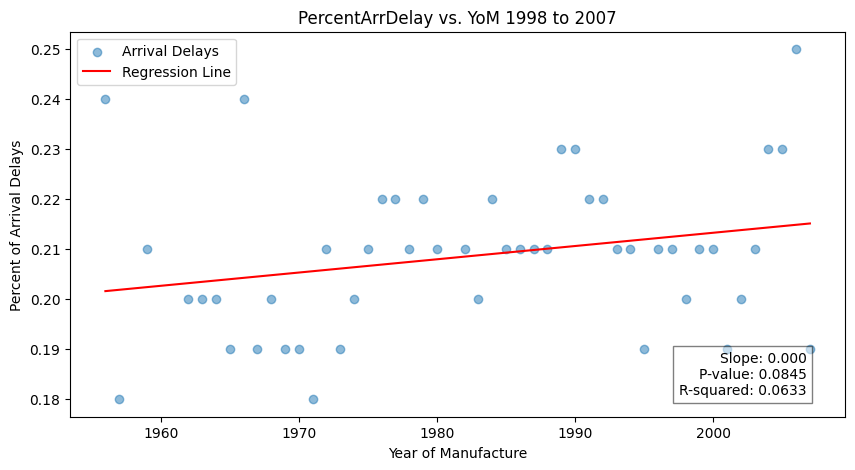

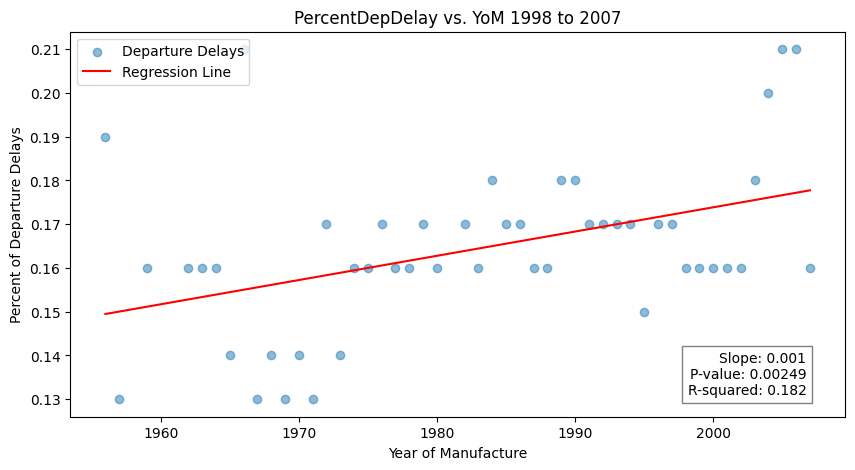

In [4]:
#Part 3 - Visualisation 1
#Below we use the dataframe produced in the previous code block to plot PercentArrDelay vs YoM and PercentDepDelay vs YoM

#Visualisation of DELAY COUNT%FLIGHT COUNT (Measure of Delay Incidence)

import statsmodels.api as sm
import os

# Define independent variable (predictor)
X = sm.add_constant(final_df['YoM'])  # Adds a constant term to the predictor
# Define dependent variables (responses)
y_arr_delay = final_df['PercentArrDelay']
y_dep_delay = final_df['PercentDepDelay']

# Fit linear regression model
model_arr_delay = sm.OLS(y_arr_delay, X).fit()
model_dep_delay = sm.OLS(y_dep_delay, X).fit()

# Print the summary of the models
print(f"PercentArrDelay vs YoM {min(subset_of_years)} to {max(subset_of_years)}:")
print(model_arr_delay.summary())
print(f"\nPercentDepDelay vs YoM {min(subset_of_years)} to {max(subset_of_years)}:")
print(model_dep_delay.summary())

# Extract key results for annotations including p-values
slope_arr, intercept_arr, p_value_arr, r_squared_arr = model_arr_delay.params['YoM'], model_arr_delay.params['const'], model_arr_delay.pvalues['YoM'], model_arr_delay.rsquared
slope_dep, intercept_dep, p_value_dep, r_squared_dep = model_dep_delay.params['YoM'], model_dep_delay.params['const'], model_dep_delay.pvalues['YoM'], model_dep_delay.rsquared

annotation_arr = f"Slope: {slope_arr:.3f}\nP-value: {p_value_arr:.3g}\nR-squared: {r_squared_arr:.3g}"
annotation_dep = f"Slope: {slope_dep:.3f}\nP-value: {p_value_dep:.3g}\nR-squared: {r_squared_dep:.3g}"


# Arrival Delays
plt.figure(figsize=(10, 5))
plt.scatter(final_df['YoM'], final_df['PercentArrDelay'], alpha=0.5, label='Arrival Delays')
plt.plot(final_df['YoM'], model_arr_delay.predict(X), color='red', label='Regression Line')  # Use X instead of X1
plt.title(f'PercentArrDelay vs. YoM {min(subset_of_years)} to {max(subset_of_years)}')
plt.xlabel('Year of Manufacture')
plt.ylabel('Percent of Arrival Delays')
plt.text(0.95, 0.05, annotation_arr, fontsize=10, transform=plt.gca().transAxes, verticalalignment='bottom', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5))
plt.legend()
if not os.path.exists('./py_images'):
    os.mkdirs('./py_images')
plt.savefig(f'./py_images/2B3_ArrDelay_python.png')
plt.show()

# Departure Delays
plt.figure(figsize=(10, 5))
plt.scatter(final_df['YoM'], final_df['PercentDepDelay'], alpha=0.5, label='Departure Delays')
plt.plot(final_df['YoM'], model_dep_delay.predict(X), color='red', label='Regression Line')  # Use X instead of X1
plt.title(f'PercentDepDelay vs. YoM {min(subset_of_years)} to {max(subset_of_years)}') 
plt.xlabel('Year of Manufacture')
plt.ylabel('Percent of Departure Delays')
plt.text(0.95, 0.05, annotation_dep, fontsize=10, transform=plt.gca().transAxes, verticalalignment='bottom', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5))
plt.legend(loc='upper left')
if not os.path.exists('./py_images'):
    os.mkdirs('./py_images')
plt.savefig(f'./py_images/2B3_DepDelay_python.png')
plt.show()




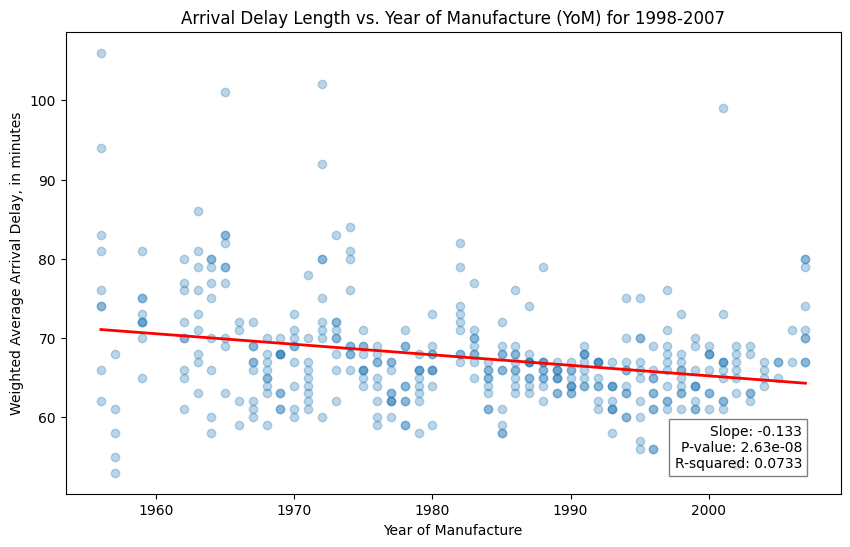

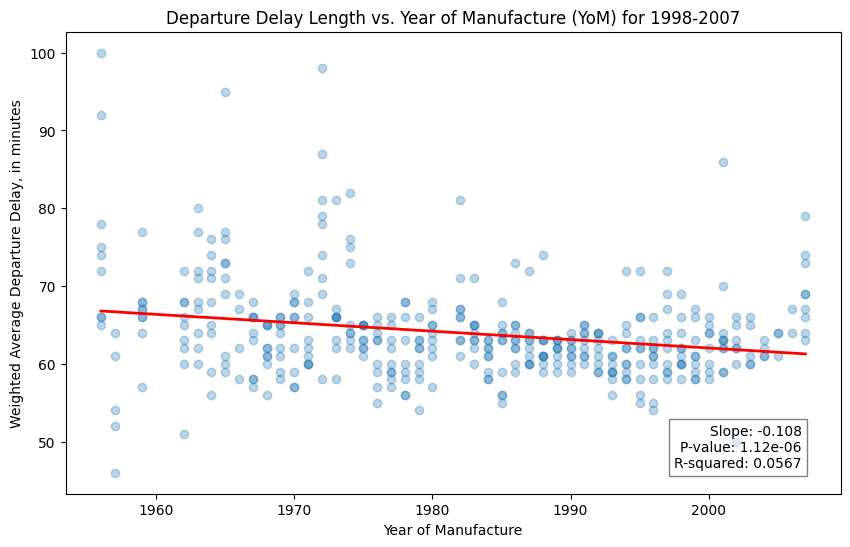

'\n\nThe length (given by WeightedAvgArrDelay and WeightedAvgDepDelay) of the delays is shorter in duration the younger the planes.\n\n\nConclusion:\nThis suggests that the improved technology means that errors, when they do occur can be fixed more quickly, albeit \ntighter regulations and attention to safety means that younger planes are delayed more frequently.\nMore data is needed to test the fidelity of our hypothesis.\n\n'

In [5]:
'''
PART (4) Weighted Average 

Output: Aggregated WeightedAvgDepDelay vs YoM AND Aggregated WeightedAvgArrDelay vs YoM

Now we produce two single plots that capture the relationship between Age and ArrDelay and Age and DepDelay for the entire date range
We also display the R**2 value (coefficient of determination) on the plots to indicate the strength of the relationship in our regression analysis. 
The R**2 value represents the proportion of the variance in the dependent variable that is predictable from the independent variable, with a value closer to 1 indicating a stronger relationship.

'''
#Part 4 - Visualisation 2
#Here we visualise a regression of Arrival Delay Length vs. Year of Manufacture (YoM) for 2004-2007 and Departure Delay Length vs. Year of Manufacture (YoM) for 2004-2007
#Here we tried a Weighted average instead
import sqlite3
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import os 

# Connect to the database
current_dir = os.getcwd()
pathname = os.path.join(current_dir, '..', 'raw_data', 'comp97to07.db') #the full path logic looks like --> go to current_dir then go to its parent then enter /raw_data/comp97to07.db
conn = sqlite3.connect(pathname)

subset_of_years = [1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007] # Adjust this list according to your compute resources available :)
all_years_df = []

for i in subset_of_years:
    join_query = f'''
    SELECT p.year AS YoM, 
        ROUND(SUM(y.ArrDelay * (y.ArrDelay / (y.ArrDelay +  y.DepDelay))) / SUM(y.ArrDelay / (y.ArrDelay + y.DepDelay)),0) AS WeightedAvgArrDelay, 
        ROUND(SUM(y.DepDelay * (y.DepDelay / (y.ArrDelay + y.DepDelay))) / SUM(y.DepDelay / (y.ArrDelay + y.DepDelay)),0) AS WeightedAvgDepDelay
    FROM Y{i} y
    INNER JOIN planes p ON y.tailnum = p.tailnum
    WHERE (y.ArrDelay >= 15 AND y.DepDelay >= 15) 
        AND p.year IS NOT NULL 
        AND p.year != 0
        AND p.year <= {max(subset_of_years)}  -- This condition only includes planes that existed before the first year in our list
    GROUP BY p.year
    ORDER BY p.year
    '''

    result = conn.execute(join_query)
    df = pd.DataFrame(result.fetchall(), columns=['YoM', 'WeightedAvgArrDelay', 'WeightedAvgDepDelay'])

    #cleaning steps
    df = df.dropna()
    df['YoM'] = pd.to_numeric(df['YoM'], errors='coerce')
    df = df.dropna()

    #print(df.tail())   

    all_years_df.append(df)

combined_df = pd.concat(all_years_df, ignore_index=True)

# Regression analysis for combined data - Arrival Delay
X = sm.add_constant(combined_df['YoM'])

# Regression analysis for combined data - Arrival Delay
model_arr = sm.OLS(combined_df['WeightedAvgArrDelay'], X).fit()
annotation_arr = f"Slope: {model_arr.params['YoM']:.3f}\nP-value: {model_arr.pvalues['YoM']:.3g}\nR-squared: {model_arr.rsquared:.3g}"

plt.figure(figsize=(10, 6))
plt.scatter(combined_df['YoM'], combined_df['WeightedAvgArrDelay'], alpha=0.3)
plt.plot(combined_df['YoM'], model_arr.predict(X), color='red', linewidth=2)
plt.title(f'Arrival Delay Length vs. Year of Manufacture (YoM) for {min(subset_of_years)}-{max(subset_of_years)}')
plt.xlabel('Year of Manufacture')
plt.ylabel('Weighted Average Arrival Delay, in minutes')
plt.text(0.95, 0.05, annotation_arr, fontsize=10, transform=plt.gca().transAxes, verticalalignment='bottom', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5))
if not os.path.exists('./py_images'):
    os.mkdirs('./py_images')
plt.savefig(f'./py_images/2B4_ArrLength_python.png')
plt.show()

# Regression analysis for combined data - Departure Delay
model_dep = sm.OLS(combined_df['WeightedAvgDepDelay'], X).fit()
annotation_dep = f"Slope: {model_dep.params['YoM']:.3f}\nP-value: {model_dep.pvalues['YoM']:.3g}\nR-squared: {model_dep.rsquared:.3g}"

plt.figure(figsize=(10, 6))
plt.scatter(combined_df['YoM'], combined_df['WeightedAvgDepDelay'], alpha=0.3)
plt.plot(combined_df['YoM'], model_dep.predict(X), color='red', linewidth=2)
plt.title(f'Departure Delay Length vs. Year of Manufacture (YoM) for {min(subset_of_years)}-{max(subset_of_years)}')
plt.xlabel('Year of Manufacture')
plt.ylabel('Weighted Average Departure Delay, in minutes')
plt.text(0.95, 0.05, annotation_dep, fontsize=10, transform=plt.gca().transAxes, verticalalignment='bottom', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5))
if not os.path.exists('./py_images'):
    os.mkdirs('./py_images')
plt.savefig(f'./py_images/2B4_DepLength_python.png')
plt.show()

conn.close()



'''

The length (given by WeightedAvgArrDelay and WeightedAvgDepDelay) of the delays is shorter in duration the younger the planes.


Conclusion:
This suggests that the improved technology means that errors, when they do occur can be fixed more quickly, albeit 
tighter regulations and attention to safety means that younger planes are delayed more frequently.
More data is needed to test the fidelity of our hypothesis.

'''




    Age  DelayIncidents  Number_of_Flights  Delays%Flights
0     0          767515            1919993        0.399749
1     1         1041579            2667096        0.390529
2     2         1113333            2787358        0.399422
3     3         1089881            2738935        0.397921
4     4          898503            2288810        0.392563
5     5          781167            2024936        0.385774
6     6          732777            1905357        0.384588
7     7          684125            1730494        0.395335
8     8          630242            1533460        0.410993
9     9          506335            1244713        0.406789
10   10          405337            1029833        0.393595
11   11          372369             975772        0.381615
12   12          334518             875502        0.382087
13   13          308212             801692        0.384452
14   14          280442             733949        0.382100
15   15          247563             627421        0.3945

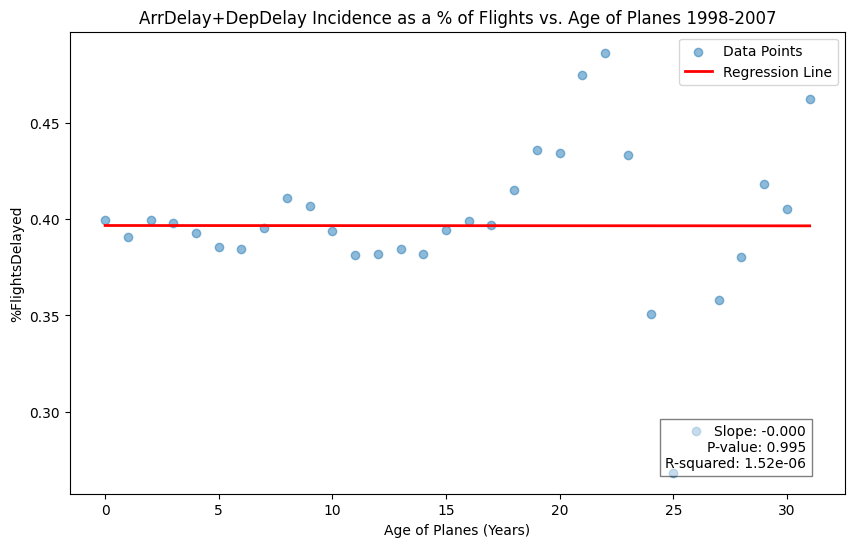

                            OLS Regression Results                            
Dep. Variable:         Delays%Flights   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.033
Method:                 Least Squares   F-statistic:                 4.546e-05
Date:                Tue, 26 Mar 2024   Prob (F-statistic):              0.995
Time:                        15:30:15   Log-Likelihood:                 55.917
No. Observations:                  32   AIC:                            -107.8
Df Residuals:                      30   BIC:                            -104.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3967      0.015     26.376      0.0

In [6]:
# Part 5 -  Visualisation 3
# Q2B Analysis 3 - AggregateDelayIncidence vs Age (in years) 
#Now let's switch things up with the age

import sqlite3
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import os 

# Connect to the database
current_dir = os.getcwd()
pathname = os.path.join(current_dir, '..', 'raw_data', 'comp97to07.db') #the full path logic looks like --> go to current_dir then go to its parent then enter /raw_data/comp97to07.db
conn = sqlite3.connect(pathname)

subset_of_years = [1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007] # Adjust this list according to your compute resources available :)
all_years_df = []


for i in subset_of_years:
  query = f'''SELECT 
        {i} - CAST(SUBSTR(p.issue_date, -4) AS INTEGER) AS Age,
        SUM(
            CASE 
                WHEN y.ArrDelay >= 15 THEN 1 
                ELSE 0 
            END
        +
            CASE 
                WHEN y.DepDelay >= 15 THEN 1 
                ELSE 0 
            END
        ) AS DelayIncidents,
        COUNT(*) AS 'Number of Flights',
        CAST(SUM(
            CASE 
                WHEN y.ArrDelay >= 15 THEN 1 
                ELSE 0 
            END
        +
            CASE 
                WHEN y.DepDelay >= 15 THEN 1 
                ELSE 0 
            END
        ) AS FLOAT) / COUNT(*) AS 'Delays%Flights'
    FROM 
        Y{i} as y
    INNER JOIN 
        planes p ON y.tailnum = p.tailnum
    WHERE
        p.year <= {max(subset_of_years)}
        AND
        CAST(SUBSTR(p.issue_date, -4) AS INTEGER) <= {i}
        AND
        y.Cancelled !=1
    GROUP BY 
        Age
    ORDER BY 
        Age DESC;
    '''

  tmp_df = pd.read_sql_query(query, conn)
  tmp_df = tmp_df.dropna()
  
  all_years_df.append(tmp_df)

combined_df_age = pd.concat(all_years_df, ignore_index=True)

# Aggregate DelayIncidents and Number of Flights for each Age across all years
final_aggregated_df = combined_df_age.groupby('Age').agg(
    DelayIncidents=('DelayIncidents', 'sum'),
    Number_of_Flights=('Number of Flights', 'sum')
).reset_index()

# Calculate Delays%Flights for aggregated values
final_aggregated_df['Delays%Flights'] = final_aggregated_df['DelayIncidents'] / final_aggregated_df['Number_of_Flights']

print(final_aggregated_df.head(20))
print(final_aggregated_df.tail(20))



# Prepare the data for regression
X = sm.add_constant(final_aggregated_df['Age'])  # Add a constant term for the intercept
Y = final_aggregated_df['Delays%Flights']

# Perform the regression
model = sm.OLS(Y, X).fit()

# Prepare annotations for the plot
annotation = f"Slope: {model.params['Age']:.3f}\nP-value: {model.pvalues['Age']:.3g}\nR-squared: {model.rsquared:.3g}"

# Create the scatter plot and regression line
plt.figure(figsize=(10, 6))
plt.scatter(final_aggregated_df['Age'], final_aggregated_df['Delays%Flights'], alpha=0.5, label='Data Points')
plt.plot(final_aggregated_df['Age'], model.predict(X), color='red', linewidth=2, label='Regression Line')

# Add titles and labels
plt.title(f'ArrDelay+DepDelay Incidence as a % of Flights vs. Age of Planes {min(subset_of_years)}-{max(subset_of_years)}')
plt.xlabel('Age of Planes (Years)')
plt.ylabel('%FlightsDelayed')

# Add the annotation text to the plot
plt.text(0.95, 0.05, annotation, fontsize=10, transform=plt.gca().transAxes, verticalalignment='bottom', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5))

# Show legend
plt.legend()

if not os.path.exists('./py_images'):
    os.mkdirs('./py_images')
# Save the plot
plt.savefig('./py_images/2B5_AggDelays_python.png')

# Show the plot
plt.show()

# Print the regression summary
print(model.summary())